In [25]:
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

# Get the Data

In [2]:
n_samples = 1000

X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42
)

len(X), len(y)

(1000, 1000)

In [3]:
circles_df = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

circles_df.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


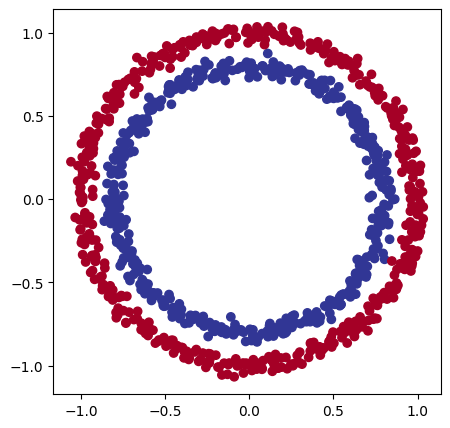

In [4]:
plt.figure(figsize=(5, 5))

plt.scatter(
    circles_df["X1"],
    circles_df["X2"],
    c=y,
    cmap=plt.cm.RdYlBu
)

plt.show()

In [24]:
circles_df.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

In [5]:
import torch

torch.__version__

'2.5.0+cu124'

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [7]:
X[:10], y[:10]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967],
         [-0.4796,  0.6764],
         [-0.0136,  0.8033],
         [ 0.7715,  0.1478],
         [-0.1693, -0.7935],
         [-0.1215,  1.0215]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [8]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test)

(800, 200)

# Build the Model

In [11]:
import torch

from torch import nn

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [13]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super(CircleModelV0, self).__init__()
        self.layer_1 = nn.Linear(
            in_features=2,
            out_features=5
        )
        self.layer_2 = nn.Linear(
            in_features=5,
            out_features=1
        )
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [14]:
model_0 = CircleModelV0().to(device)

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.4322,  0.2645],
                      [-0.0783,  0.1674],
                      [ 0.5767, -0.2817],
                      [ 0.6799,  0.4722],
                      [-0.6025,  0.6671]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.5027,  0.3143,  0.2507,  0.2381,  0.5788], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.2884, -0.0393, -0.3596,  0.0818,  0.2894]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.4074], device='cuda:0'))])

In [16]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [17]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super(CircleModelV1, self).__init__()
        self.layer_1 = nn.Linear(
            in_features=2,
            out_features=5
        )
        self.layer_2 = nn.Linear(
            in_features=5,
            out_features=1
        )

        self.two_linear_layers = nn.Sequential(
            self.layer_1,
            self.layer_2
        )
        
    def forward(self, x):
        return self.two_linear_layers(x)

In [18]:
model_1 = CircleModelV1().to(device)

model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [19]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.0622,  0.0907],
                      [-0.5752,  0.4736],
                      [-0.5989,  0.6434],
                      [-0.1377,  0.3367],
                      [ 0.1991, -0.1475]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.1868,  0.6247,  0.7030, -0.0436,  0.5989], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.3383, -0.2761, -0.3724, -0.0445, -0.2377]], device='cuda:0')),
             ('layer_2.bias', tensor([0.4234], device='cuda:0')),
             ('two_linear_layers.0.weight',
              tensor([[-0.0622,  0.0907],
                      [-0.5752,  0.4736],
                      [-0.5989,  0.6434],
                      [-0.1377,  0.3367],
                      [ 0.1991, -0.1475]], device='cuda:0')),
             ('two_linear_layers.0.bias',
              tensor([-0.1868,  0.6247,  0.7030, -0.0436,  0.5989], device='cuda:0')),
             ('two_linear_layer

In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [21]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100

    return acc

# Train the Model

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [23]:
epochs = 100

X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.no_grad():
        y_logits = model_0(X_test).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        test_loss = loss_fn(y_logits, y_test)
        test_acc = accuracy_fn(y_test, y_pred)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | loss: {loss:.2f} | acc: {acc:.2f} | test_loss: {test_loss:.2f} | test_acc: {test_acc:.2f}")

Epoch: 0 | loss: 0.70 | acc: 48.25 | test_loss: 0.70 | test_acc: 43.50
Epoch: 10 | loss: 0.69 | acc: 52.12 | test_loss: 0.70 | test_acc: 47.50
Epoch: 20 | loss: 0.69 | acc: 50.12 | test_loss: 0.69 | test_acc: 49.00
Epoch: 30 | loss: 0.69 | acc: 50.88 | test_loss: 0.69 | test_acc: 51.00
Epoch: 40 | loss: 0.69 | acc: 50.62 | test_loss: 0.69 | test_acc: 45.50
Epoch: 50 | loss: 0.69 | acc: 51.62 | test_loss: 0.70 | test_acc: 46.50
Epoch: 60 | loss: 0.69 | acc: 51.50 | test_loss: 0.69 | test_acc: 46.00
Epoch: 70 | loss: 0.69 | acc: 51.25 | test_loss: 0.69 | test_acc: 45.00
Epoch: 80 | loss: 0.69 | acc: 51.25 | test_loss: 0.69 | test_acc: 45.50
Epoch: 90 | loss: 0.69 | acc: 51.62 | test_loss: 0.69 | test_acc: 45.50


In [28]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    model.to("cpu")
    X, y = X.cpu(), y.cpu()
    
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    xx, yy = torch.meshgrid(
        torch.linspace(x_min, x_max, 101),
        torch.linspace(y_min, y_max, 101)
    )

    X_to_predict = torch.from_numpy(np.column_stack([xx.ravel(), yy.ravel()])).float()

    model.eval()

    with torch.inference_mode():
        y_logits = model(X_to_predict)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()

    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.show()

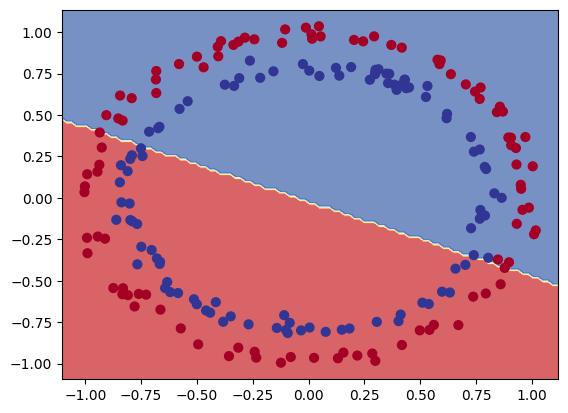

In [29]:
plot_decision_boundary(model_0, X_test, y_test)